# Data Exploratory to Answer Question in task 1

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:

#import custome modules
sys.path.append('../')

from scripts.get_missing_information import MissingInformation
from scripts.get_dataframe_information import DataFrameInformation
from scripts.ploting_utils import Plotters
from scripts.data_clean_handler import CleanData
from scripts import data_loader

cleaner = CleanData()
minfo = MissingInformation()
dinfo = DataFrameInformation()
pltu = Plotters(6,4)

In [4]:
train_df = pd.read_csv('../data/merged/train.csv')
test_df = pd.read_csv('../data/merged/test.csv')

In [5]:

# # First load the cleaned stores data
# data_path = 'data/cleaned/store.csv'
# version = 'stores_missing_filled_v2'
# repo = '../'

# store_df = data_loader.dvc_get_data(data_path, version, repo)

# # Then load the raw sales data
# data_path = 'data/raw/train.csv'
# version = 'raw_data'
# repo = '../'

# train_df = data_loader.dvc_get_data(data_path, version, repo)

# # Finally load the test data
# data_path = 'data/raw/test.csv'
# version = 'raw_data'
# repo = '../'

# test_df = data_loader.dvc_get_data(data_path, version, repo)


### 1. Are the promotions distributed similarly in both training and test sets?

YES


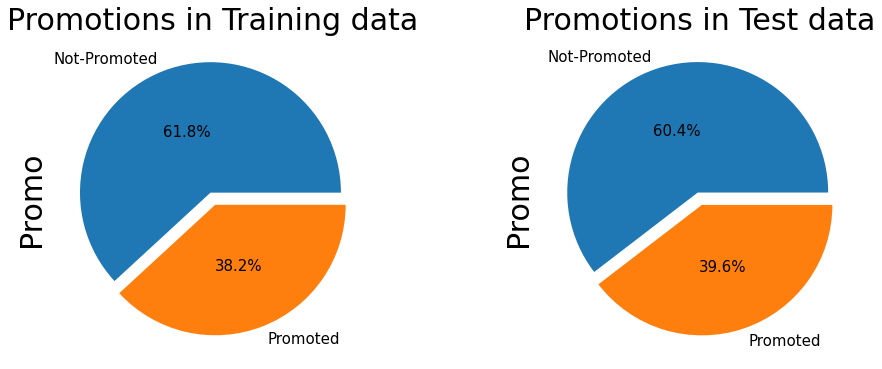

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

lable_font_size = 30
textprops = {"fontsize": 15}
labels = {'Not-Promoted': 0, 'Promoted': 1}
train_promo_count = train_df["Promo"].value_counts().to_frame()

# plt.title("Ratio of overall promotions",
#           fontsize=20, loc='left')
axs[0].pie(data=train_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )
axs[0].set_label(labels)
axs[0].set_ylabel('Promo', fontsize=lable_font_size)
# axs[0].set_label(labels, fontsize=lable_font_size)
axs[0].set_title('Promotions in Training data', fontsize=lable_font_size)

test_promo_count = test_df["Promo"].value_counts().to_frame()
axs[1].pie(data=test_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )

axs[1].set_ylabel('Promo', fontsize=lable_font_size)
axs[1].set_title('Promotions in Test data', fontsize=lable_font_size)


print("YES")


##### The distribution of data in the train and test is almost somilar. What is frequently found in the train are also found in the test



## 2. What does sales behavior look like before, during and after holidays?

Let us first look at how the holidays are distributed

StateHoliday

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass



In [7]:
christmas = train_df.query("StateHoliday=='c'")
christmas_dates = christmas.groupby('Date')['Date'].unique().index
christmas_dates = pd.to_datetime(christmas_dates)
print(
    f"There are {christmas_dates.shape[0]} christmas_dates\n{christmas_dates}")


There are 4 christmas_dates
DatetimeIndex(['2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26'], dtype='datetime64[ns]', name='Date', freq=None)


In [8]:
grouped_by_date = train_df.groupby(
    'Date')[['Customers', 'Sales', 'SalesPerCustomer']]
grouped_by_date = grouped_by_date.sum()
grouped_by_date.head()


,Customers,Sales,SalesPerCustomer
Date,,,
2013-01-01,19491,97235,84.826752
2013-01-02,834075,6949829,9708.032399
2013-01-03,761040,6347820,9709.819394
2013-01-04,782137,6638954,9818.033076
2013-01-05,687472,5951593,9971.772244


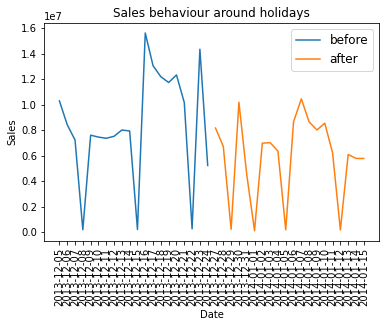

In [9]:
from turtle import color

before_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) < christmas_dates[0]].index[-20:]
after_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) > christmas_dates[1]].index[:20]
during_christmass_idx = christmas_dates[:2]

before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]

# sns.set()
sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])
ax = sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
ax.set_title("Sales behaviour around holidays")
plt.xticks(rotation=90)
ax.legend(['before', 'after', 'during'], fontsize=12)


## 3. Are there any seasonal (Christmas, Easter etc) purchase behaviours?

In [10]:
import plotly.express as px
import pandas as pd
seasonal_grouped_by_date = train_df.groupby(
    'Date')[['Customers', 'Sales', 'SalesPerCustomer']].sum().reset_index()
fig = px.line(seasonal_grouped_by_date, x='Date', y='Sales',
              title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [11]:
fig = px.scatter(seasonal_grouped_by_date, x='Date', y='Sales', range_x=['2013-01-01', '2015-07-31'],
                 title="Default Display with Gaps")
fig.show()


In [12]:

fig = px.scatter(seasonal_grouped_by_date, x='Date', y='Sales', range_x=['2013-01-01', '2015-07-31'],
                 title="Hide Weekend and Holiday Gaps with rangebreaks")
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]),  # hide weekends
        # hide Christmas and New Year's
        dict(values=["2015-12-25", "2016-01-01"])
    ]
)
fig.show()


## 4. Correlation between sales and number of customers

Text(0.5, 1.0, 'Correlation map of selected sales and store features')

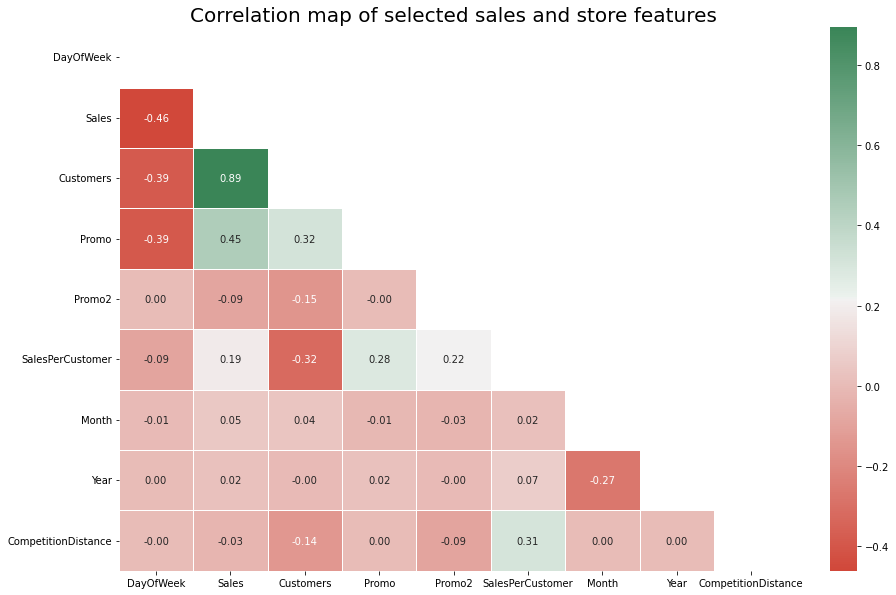

In [13]:
df_correlation = train_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
                           'Promo2', 'SalesPerCustomer', 'Month', 'Year',
                           'StateHoliday', 'Assortment', 'StoreType',
                           'PromoInterval', 'CompetitionDistance']]

df_correlation = df_correlation.drop('Open', axis=1)
upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(15, 500, as_cmap=True))
ax.set_title(
    "Correlation map of selected sales and store features", fontsize=20)


## 5. How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

In [14]:
grouped_by_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['Sales'].describe().transpose()
grouped_by_promo


Promo,0,1
count,467463.000000,376875.000000
mean,5929.826183,8228.739731
std,2629.269229,3175.253594
min,46.000000,133.000000
25%,4242.000000,6070.000000
50%,5459.000000,7650.000000
75%,7004.000000,9686.000000
max,41551.000000,38722.000000


Text(0.5, 1.0, 'Average Sales vs Promo')

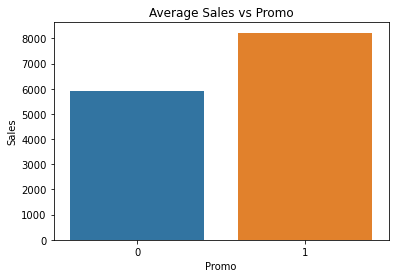

In [15]:
mean_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['Sales'].mean().to_frame()
ax = sns.barplot(data=mean_sale_promo, x=mean_sale_promo.index, y='Sales')
ax.set_title("Average Sales vs Promo")


,SalesPerCustomer
Promo,
0,4.179646e+06
1,3.836196e+06


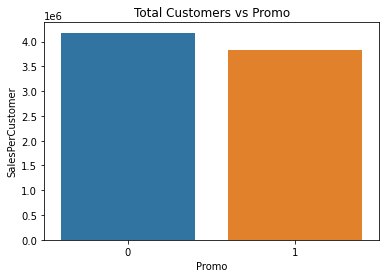

In [16]:
total_customers_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['SalesPerCustomer'].sum().to_frame()
ax = sns.barplot(data=total_customers_promo,
                 x=total_customers_promo.index, y='SalesPerCustomer')
ax.set_title("Total Customers vs Promo")
total_customers_promo


- The promo increases by increasing the amount of sales per customer.
- It makes some people to stay away from the store. 
- It is not attracting more customers, instead it is making some customers to spend more. 

## 6. Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

In [17]:
grouped_by_store = train_df.groupby('Store')[['Sales', 'Customers']].sum()
grouped_by_store.head()


,Sales,Customers
Store,,
1,3716854,440523
2,3883858,457855
3,5408261,584310
4,7556507,1036254
5,3642818,418588


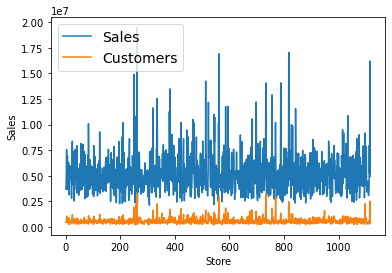

In [18]:
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Sales')
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Customers')
plt.legend(['Sales', 'Customers'], fontsize=14)


## 7. Trends of customer behavior during store open and closing times


## 8. Which stores are opened on all weekdays? How does that affect their sales on weekends?

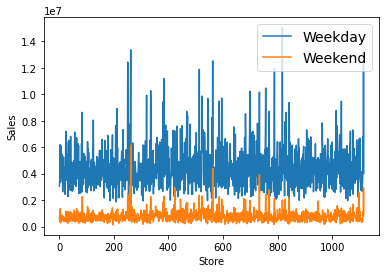

In [19]:
# stores_open_on_weekdays = train_df.query("DayOfWeek!=7 & DayOfWeek!=6 & Open==1")['Store'].unique()
stores_open_on_weekdays = train_df.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(
    stores_open_on_weekdays) & train_df['Open'] == 1 & ~train_df['DayOfWeek'].isin([6, 7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(
    stores_open_on_weekdays) & train_df['Open'] == 1 & train_df['DayOfWeek'].isin([6, 7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
plt.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')


Sales on Weekends are significanly lower than on weekdays. But, I can't be certain that this has to do with the fact that they were also open during the week days. Most stores are closed on weekends, so sales are generally down on weekends.

## 9. How does assortment type affects sales?

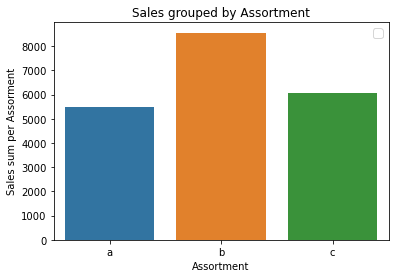

In [20]:
grouped_by_year_assortment = train_df.groupby(
    ['Assortment'])['Sales'].mean().to_frame()
ax = sns.barplot(x=grouped_by_year_assortment.index,
                 y=grouped_by_year_assortment['Sales'].values,
                 # xlabel="Assortment",
                 # ylabel='Sales sum per Assorment',
                 # title='Sales grouped by Assortment'
                 )
ax.set_ylabel('Sales sum per Assorment')
ax.set_title('Sales grouped by Assortment')
plt.legend(fontsize=12)


Assortment type 'b' Has the largest mean sales followed by 'c' and 'a'

## 10. How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

Text(0.5, 0, 'CompetitionDistance')

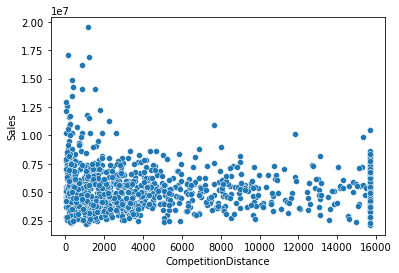

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# comp_dist = scaler.fit_transform(
comp_dist = train_df.groupby('Store')[['CompetitionDistance']].min()  # )[:, 0]
# store_sales = scaler.fit_transform(
store_sales = train_df.groupby('Store')[['Sales']].sum()  # )[:, 0]

ax = sns.scatterplot(x=comp_dist.values[:, 0], y=store_sales.values[:, 0])
ax.set_ylabel('Sales')
ax.set_xlabel('CompetitionDistance')


- The increase in competition distance  do not increase sales. 
- Most of the store has competition but do not show difference in their sales compared to those with no less competition
- May be having more competition indicates the demand increase in the area. There may be anotheer factor

## 11. How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance


In [33]:
grouped_by_date = train_df.groupby(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'])[['Store']].count()
grouped_by_date
 
 

Store
CompetitionOpenSinceYear CompetitionOpenSinceMonth       
1900.0                   1.0                          758
1961.0                   10.0                         942
1990.0                   6.0                         1884
                         7.0                         2826
1994.0                   11.0                        1884
...                                                   ...
2015.0                   4.0                         8478
                         5.0                         5468
                         6.0                         4710
                         7.0                         7168
                         8.0                         2826

[171 rows x 1 columns]